# **Accident Severity Classification**

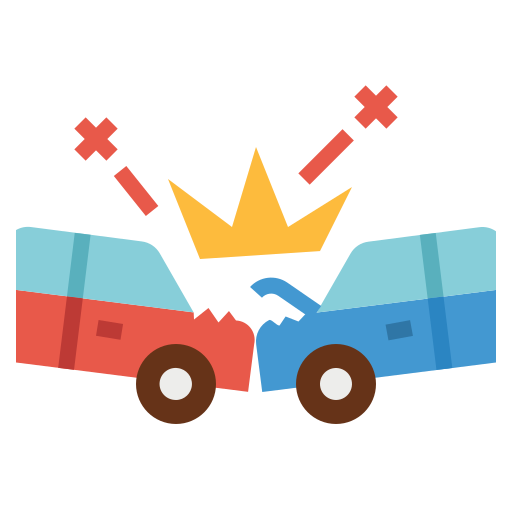

# **Outline**
1. **Introduction**
2. **Data preparation **
    * 2.1 Load data
    * 2.2 Sample the data
    * 2.3 Check for missing values (NaN)
    * 2.4 Exploratory Visualization
    * 2.5 Create a new dataframe
    * 2.6 Split features and targets from the data
3. **Training/Predicting Pipeline**
4. **Prediction and submission**
    * 4.1 Logistic Regression
    * 4.2 Random Forest Classifier
    * 4.3 Using the Full Estimator

# **1. Introduction**

The UK government collects and publishes (usually on an annual basis) detailed information about traffic accidents across the country. This information includes, but is not limited to, geographical locations, weather conditions, type of vehicles, number of casualties and vehicle manoeuvres, making this a very interesting and comprehensive dataset for analysis and research.

The data come from the Open Data website of the UK government, where they have been published by the Department of Transport.

The dataset comprises of two csv files:

* Accident_Information.csv: every line in the file represents a unique traffic accident (identified by the Accident_Index column), featuring various properties related to the accident as columns. Date range: 2005-2017
* Vehicle_Information.csv: every line in the file represents the involvement of a unique vehicle in a unique traffic accident, featuring various vehicle and passenger properties as columns. Date range: 2004-2016

Our target is to predict the accident severity. The severity is devided to two catagories; severe and slight.

We had more than 2 million observations and close to 60 features. So, we sampled the data into about 600K observations and 23 features.

Two models were selected - Logistic Regression and the Random Forest Classifier.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from pandas.tools.plotting import scatter_matrix
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import seaborn as sns
sns.set()
import math

warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Vehicle_Information.csv', 'Accident_Information.csv']


# **2. Data Preparation**
## **2.1 Load Data**

In [2]:
#Load Data and encode to latin
acc = pd.read_csv('C:/Users/digit/Downloads/data/Accident_Information.csv', encoding = 'latin')
veh = pd.read_csv('C:/Users/digit/Downloads/data/Vehicle_Information.csv', encoding = 'latin')

# Merging two data sets into one with inner join by index
df = pd.merge(veh, acc, how = 'inner', on = 'Accident_Index')

#Check data sample
print(df.shape)
df.head()

(2058408, 57)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_x,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_y,InScotland
0,200501BS00002,36 - 45,3.0,Data missing or out of range,NaN,8268.0,None,None,Journey as part of work,Leaving roundabout,DENNIS,NaN,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,0.0,Slowing or stopping,1,Bus or coach (17 or more pass seats),No,Nearside,2005,B,450.0,C,0.0,Slight,None,2005-01-05,Wednesday,1.0,Auto traffic signal,Crossroads,51.520075,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.0,181650.0,-0.211708,E01002909,1,1,0.0,5.0,Metropolitan Police,Dry,Dual carriageway,None,30.0,17:36,Urban,Fine no high winds,2005,No
1,200501BS00003,26 - 35,5.0,Urban area,3.0,8300.0,Parked vehicle,None,Journey as part of work,Not at or within 20 metres of junction,DENNIS,NaN,Heavy oil,Male,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead right-hand bend,1,Bus or coach (17 or more pass seats),No,Nearside,2005,C,0.0,NaN,0.0,Slight,None,2005-01-06,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.525301,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524520.0,182240.0,-0.206458,E01002857,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,00:15,Urban,Fine no high winds,2005,No
2,200501BS00004,46 - 55,4.0,Urban area,1.0,1769.0,None,None,Other/Not known (2005-10),Not at or within 20 metres of junction,NISSAN,ALMERA SE AUTO,Petrol,Female,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Car,No,Front,2005,A,3220.0,NaN,0.0,Slight,None,2005-01-07,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.482442,Daylight,Kensington and Chelsea,Kensington and Chelsea,526900.0,177530.0,-0.173862,E01002840,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30.0,10:35,Urban,Fine no high winds,2005,No
3,200501BS00005,46 - 55,10.0,Data missing or out of range,NaN,85.0,Kerb,None,Other/Not known (2005-10),Not at or within 20 metres of junction,HONDA,NaN,Petrol,Male,Skidded,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Front,2005,Unclassified,0.0,NaN,0.0,Slight,None,2005-01-10,Monday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.495752,Darkness - lighting unknown,Kensington and Chelsea,Kensington and Chelsea,528060.0,179040.0,-0.156618,E01002863,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,21:13,Urban,Fine no high winds,2005,No
4,200501BS00006,46 - 55,1.0,Urban area,4.0,2976.0,None,None,Other/Not known (2005-10),Not at or within 20 metres of junction,AUDI,A4 SPORT CABRIOLET AUTO,Petrol,Male,None,No tow/articulation,Did not leave carriageway,0.0,Moving off,1,Car,No,Did not impact,2005,Unclassified,0.0,NaN,0.0,Slight,None,2005-01-11,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.515540,Daylight,Kensington and Chelsea,Kensington and Chelsea,524770.0,181160.0,-0.203238,E01002832,1,

## **2.2 Sample the data** 
### by reducing rows with Slight Accident Severity


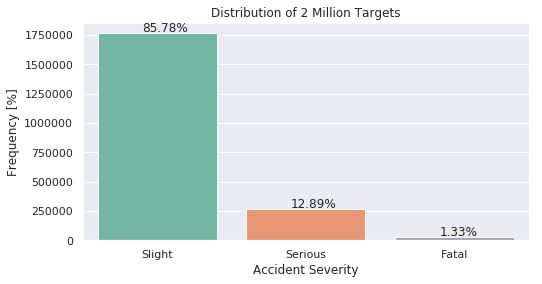

In [3]:
#Distribution of original data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 2 Million Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()


In [4]:
# Creating weights that are opposite to the weights of target
weights = np.where(df['Accident_Severity'] == 'Slight', .2, .8)

#Sampling only 30% of the data with new weights  
df = df.sample(frac=0.3, replace=True, weights=weights)
print(df.shape)
#df.Accident_Severity.value_counts(normalize=True)

(617522, 57)


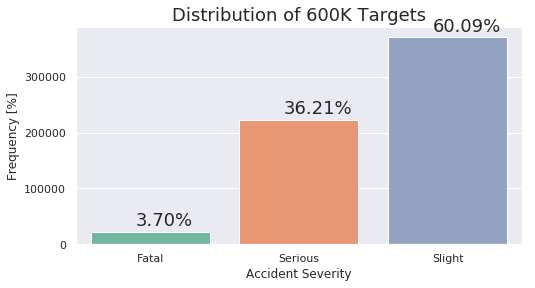

In [5]:
#Distribution of sample data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 600K Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()


## **2.3 Check for missing values (NaN)**
### some will be filled, some will get omitted

In [6]:
#Missing values for each column
null_count = df.isnull().sum()
null_count[null_count>0]#.plot('bar', figsize=(30,10))

Age_of_Vehicle                                 102920
Driver_IMD_Decile                              206616
Engine_Capacity_.CC.                            76213
make                                            34503
model                                           96628
Propulsion_Code                                 71130
Vehicle_Location.Restricted_Lane                  300
2nd_Road_Class                                 263982
2nd_Road_Number                                  5998
Did_Police_Officer_Attend_Scene_of_Accident        43
Latitude                                           36
Location_Easting_OSGR                              36
Location_Northing_OSGR                             36
Longitude                                          36
LSOA_of_Accident_Location                       44560
Pedestrian_Crossing-Human_Control                 210
Pedestrian_Crossing-Physical_Facilities           395
Speed_limit                                        23
Time                        

## **2.4 Exploratory Visualization**
### **Age of Vehicle**

Min: 1.0 
Max: 111.0 
Median: 7.0


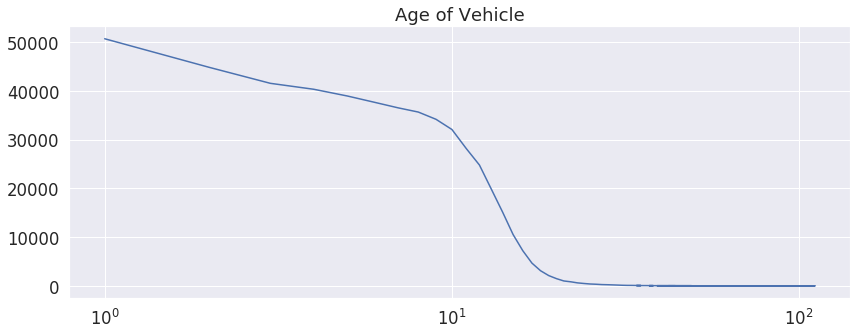

In [7]:
(df.Age_of_Vehicle
 .value_counts()
 .plot(title = "Age of Vehicle", 
       logx = True, 
       figsize=(14,5)))

print('Min:',    df.Age_of_Vehicle.min(), '\n'
      'Max:',    df.Age_of_Vehicle.max(), '\n'
      'Median:', df.Age_of_Vehicle.median())

### **Engine capacity feature**

Min: 1.0 
Max: 91000.0 
Median: 1598.0


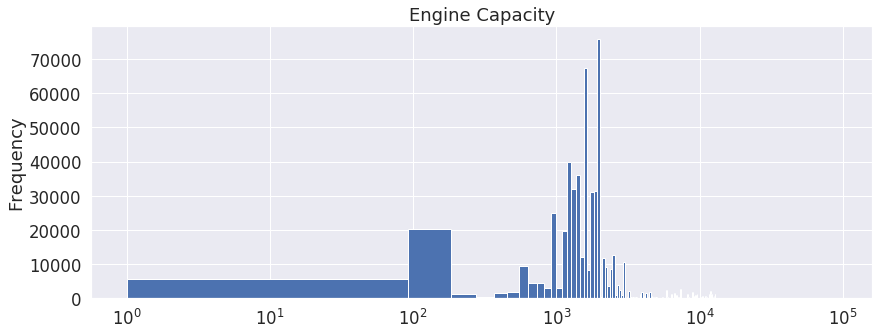

In [8]:
(df['Engine_Capacity_.CC.']
 .plot('hist',
       bins = 1000,
       title = "Engine Capacity", 
       figsize=(14,5),
       logx = True
      ))

print('Min:',    df['Engine_Capacity_.CC.'].min(), '\n'
      'Max:',    df['Engine_Capacity_.CC.'].max(), '\n'
      'Median:', df['Engine_Capacity_.CC.'].median())

## **2.5 Create a new dataframe** 
### with only the features we need and want, **25 features overall**

In [9]:
df2 = df[['Accident_Index', '1st_Road_Class','Day_of_Week', 'Junction_Detail','Light_Conditions', 'Number_of_Casualties',
          'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit',
          'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Age_of_Vehicle',
          'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'make', 'Engine_Capacity_.CC.', 'Sex_of_Driver',
          'Skidding_and_Overturning', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Accident_Severity'
         ]]

## **Correlation matrix**

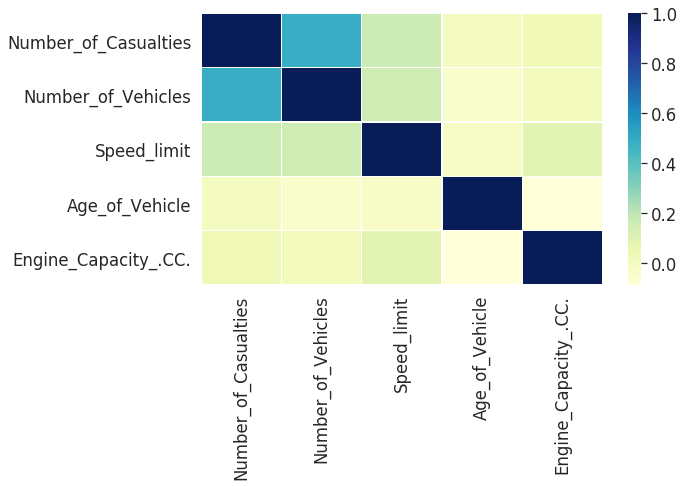

In [10]:
plt.figure(figsize=(9,5))
sns.heatmap(df2.corr(),linewidths=.5,cmap="YlGnBu")
plt.show()

## **Number of vehicles distribution**

Min: 1 
Max: 67 
Median: 2.0


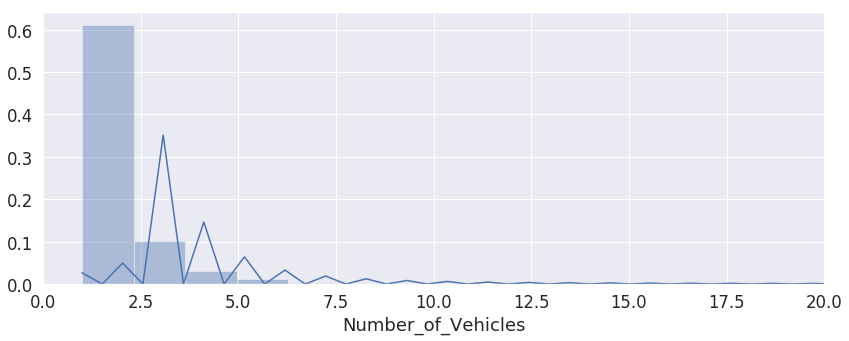

In [11]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Vehicles).set_xlim(0,20)
print('Min:',    df2.Number_of_Vehicles.min(), '\n'
      'Max:',    df2.Number_of_Vehicles.max(), '\n'
      'Median:', df2.Number_of_Vehicles.median())

## **Number of casualties distribution**

Min: 1 
Max: 93 
Median: 1.0


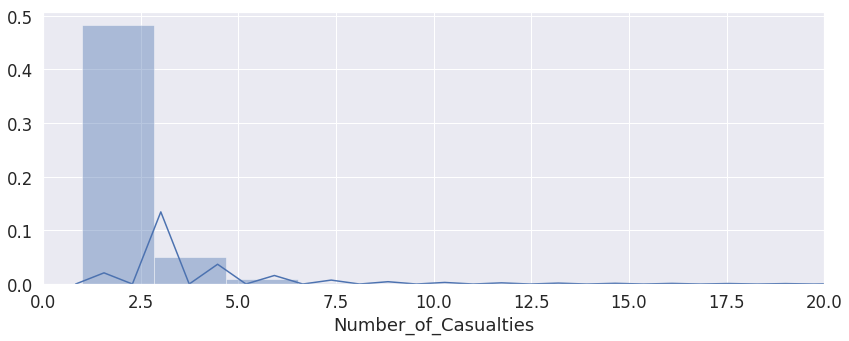

In [12]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Casualties).set_xlim(0,20)
print('Min:',    df2.Number_of_Casualties.min(), '\n'
      'Max:',    df2.Number_of_Casualties.max(), '\n'
      'Median:', df2.Number_of_Casualties.median())

## ** Distribution of accidents over the day**

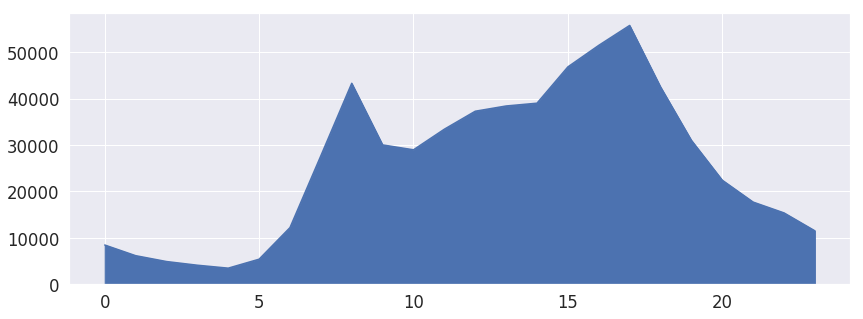

In [13]:
time_x = pd.to_datetime(df2['Time'], format='%H:%M').dt.hour
plt.figure(figsize=(14,5))
time_x.value_counts().sort_index().plot('area')

## **From multiclass to two-classes**

In [14]:
df2['Accident_Severity'] = df2['Accident_Severity'].replace(['Serious', 'Fatal'], 'Serious or Fatal')
df2 = pd.get_dummies(df2, columns=['Accident_Severity'])
df2 = df2.drop('Accident_Severity_Serious or Fatal', axis=1)
df2.Accident_Severity_Slight.value_counts(normalize=True)

1    0.600861
0    0.399139
Name: Accident_Severity_Slight, dtype: float64

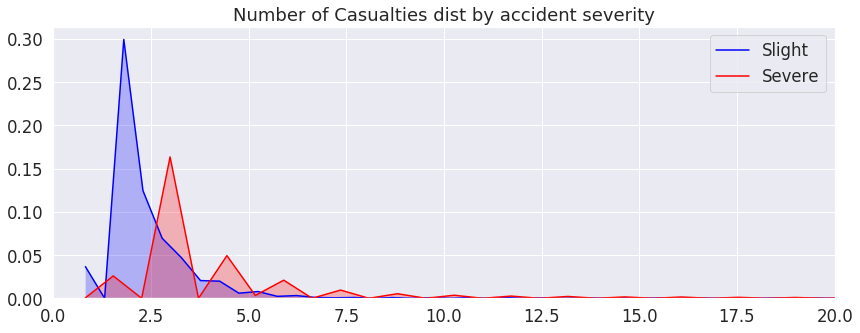

In [15]:
plt.figure(figsize=(14,5))
acc_slight = df2.Accident_Severity_Slight == 1
acc_severe = df2.Accident_Severity_Slight == 0

sns.kdeplot(df2.Number_of_Casualties[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Casualties[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of Casualties dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")


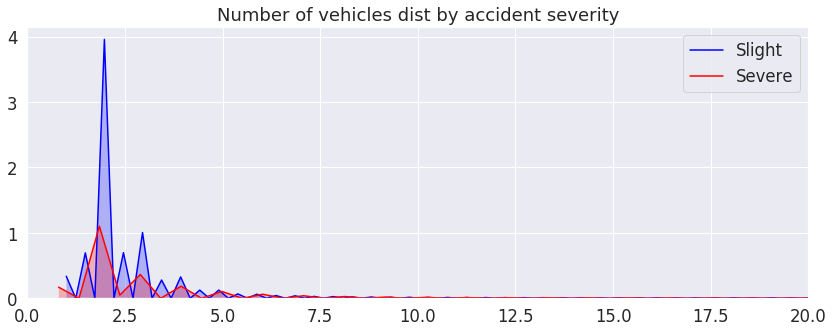

In [16]:
plt.figure(figsize=(14,5))

sns.kdeplot(df2.Number_of_Vehicles[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Vehicles[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of vehicles dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")


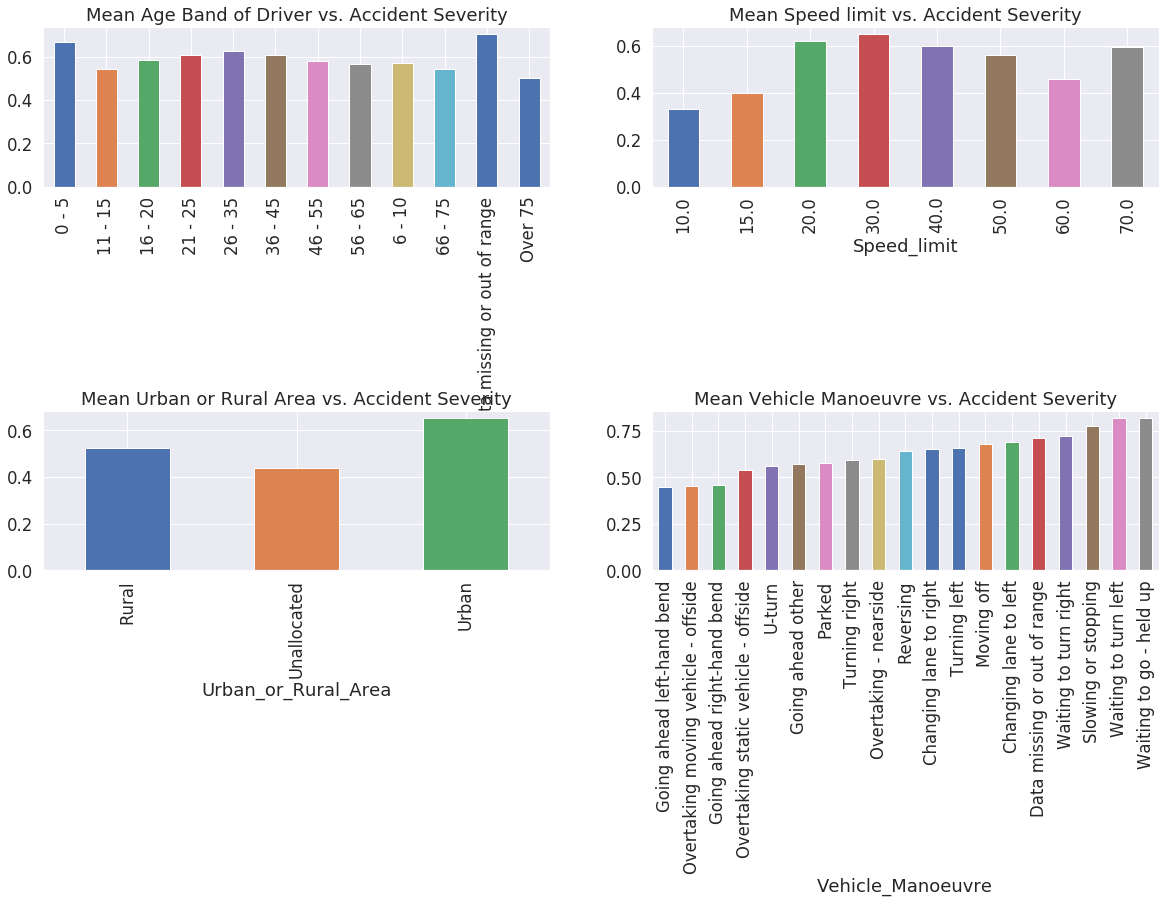

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plt.subplots_adjust(hspace=1.4)

(df2.groupby(['Age_Band_of_Driver'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_index()
 .plot
 .bar(title = "Mean Age Band of Driver vs. Accident Severity",
      ax = axes[0,0]))

(df2.groupby(['Speed_limit'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_index()
 .plot
 .bar(title = "Mean Speed limit vs. Accident Severity",
      ax = axes[0,1]))

(df2.groupby(['Urban_or_Rural_Area'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_index()
 .plot
 .bar(title = "Mean Urban or Rural Area vs. Accident Severity",
      ax = axes[1,0]))

(df2.groupby(['Vehicle_Manoeuvre'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_values()
 .plot
 .bar(title = "Mean Vehicle Manoeuvre vs. Accident Severity",
      ax = axes[1,1]))

plt.show()

## **2.6 Split features and targets from the data**

In [18]:
X = df2.drop(['Accident_Index','Accident_Severity_Slight'], axis=1)
y = df2.Accident_Severity_Slight
print(X.shape,
      y.shape)

(617522, 23) (617522,)


# **3. Training/Predicting Pipeline**
## **Transform Speed Limit**

In [19]:
def get_Speed_limit(df):
    return df[['Speed_limit']]

FullTransformerOnSpeedLimit = Pipeline([("Select_Speed_Limit", FunctionTransformer(func=get_Speed_limit, validate=False)),
                                        ("Fill_Null",          SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                        ("One_Hot_Encoder",    OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                       ])

#FullTransformerOnSpeedLimit.fit_transform(X[:5000], y[:5000])

## **Transform Time**

In [20]:
def get_Time(df):
    return pd.to_datetime(df['Time'], format='%H:%M').dt.time

def find_time_group(time_object):
    if time_object<pd.datetime.time(pd.datetime(2000,1,1,5,0)):
        return 'Night'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,7,0)):
        return 'Early Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,10,0)):
        return 'Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,15,0)):
        return 'Midday'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,18,0)):
        return 'Afternoon'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,20,0)):
        return 'Evening'
    elif time_object<=pd.datetime.time(pd.datetime(2000,1,1,23,59)):
        return 'Late Evening'
    return np.nan

FullTransformerOnTime = Pipeline([("Select_Time",     FunctionTransformer(func=get_Time, validate=False)),
                                  ("Group_Time",      FunctionTransformer(func=lambda x: x.apply(find_time_group).to_frame(), validate=False)),
                                  ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                  ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                 ])

#FullTransformerOnTime.fit_transform(X[:5000], y[:5000])

## **Transform Age of Vehicle**

In [21]:
def get_Age_of_Vehicle(df):
    return df[['Age_of_Vehicle']]

FullTransformerOnAgeofVehicle = Pipeline([("Select_Age_of_Vehicle", FunctionTransformer(func=get_Age_of_Vehicle, validate=False)),
                                          ("Fill_Null",             SimpleImputer(missing_values=np.nan, strategy='median'))
                                         ])

#FullTransformerOnAgeofVehicle.fit_transform(X[:5000], y[:5000])

## **Transform Make**

In [22]:
def get_make(df):
    list_of_small_makers = list(df['make'].value_counts()[df['make'].value_counts() < 2000].index)
    return df['make'].replace(list_of_small_makers, 'Other').to_frame()

FullTransformerOnMake = Pipeline([("Select_Make",      FunctionTransformer(func=get_make, validate=False)),
                                   ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Other')),
                                   ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))])

#FullTransformerOnMake.fit_transform(X[:5000], y[:5000])

## **Transform Engine Capacity**

In [23]:
def get_Engine_Capacity(df):
    return df[['Engine_Capacity_.CC.']]

FullTransformerOnEngineCapacity = Pipeline([("Select_Engine_Capacity",       FunctionTransformer(func=get_Engine_Capacity, validate=False)),
                                            ("Fill_Null",                    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                            ("Car_Types_by_Engine_Capacity", KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')),
                                            ("One_Hot_Encoder",              OneHotEncoder(sparse = False, handle_unknown='ignore'))
                                           ])

#FullTransformerOnEngineCapacity.fit_transform(X[:5000], y[:5000])
#FullTransformerOnEngineCapacity.named_steps["Car_Types_by_Engine_Capacity"].bin_edges_[0]

## **Data To OneHot Transformer On Columns**

In [24]:
def get_columns_to_one_hot(df):
    return df[['1st_Road_Class', 'Day_of_Week', 'Junction_Detail', 'Light_Conditions', 'Number_of_Casualties', 
               'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 
               'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Hit_Object_in_Carriageway',
               'Hit_Object_off_Carriageway', 'Sex_of_Driver', 'Skidding_and_Overturning',
               'Vehicle_Manoeuvre', 'Vehicle_Type'
              ]]

DataToOneHotTransformerOnColumns = Pipeline([("Select_Columns",  FunctionTransformer(func=get_columns_to_one_hot, validate=False)),
                                             ("One_Hot_Encoder", OneHotEncoder(sparse = False, handle_unknown='ignore'))])

#DataToOneHotTransformerOnColumns.fit_transform(X[:5000], y[:5000])

## **Feature Union**

In [25]:
FeatureUnionTransformer = FeatureUnion([
                                        ("FTAgeofVehicle",   FullTransformerOnAgeofVehicle),
                                        ("FTEngineCapacity", FullTransformerOnEngineCapacity),
                                        ("FTMake",           FullTransformerOnMake),
                                        ("FTSpeedLimit",     FullTransformerOnSpeedLimit),
                                        ("FTTime",           FullTransformerOnTime),
                                        ("OHEColumns",       DataToOneHotTransformerOnColumns)])

#FeatureUnionTransformer.fit_transform(X[:5000], y[:5000])

In [26]:
Full_Transformer = Pipeline([
                           ("Feature_Engineering", FeatureUnionTransformer),
                           ("Min_Max_Transformer", MaxAbsScaler())
                           ])

#Full_Transformer.fit(X[:5000], y[:5000])

# **4. Prediction and submission**

In [27]:
X_train, X_test, y_train, y_test = split(X, y)

## **4.1 Logistic Regression**

In [28]:
%%time

clf = LogisticRegression(class_weight = "balanced")

Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)
clf.fit(X_train_transformed, y_train)

X_test_transformed = Full_Transformer.transform(X_test)

y_pred = clf.predict(X_test_transformed)

print('Classification Report:',classification_report(y_test, y_pred))

print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))

Classification Report:               precision    recall  f1-score   support

           0       0.56      0.65      0.60     61278
           1       0.74      0.66      0.70     93103

   micro avg       0.66      0.66      0.66    154381
   macro avg       0.65      0.65      0.65    154381
weighted avg       0.67      0.66      0.66    154381

Score: 0.7110141886723705
CPU times: user 2min 34s, sys: 6.93 s, total: 2min 41s
Wall time: 2min 40s


## **4.2 Random Forest Classifier**

In [29]:
%%time

clf = RandomForestClassifier(n_estimators=100, n_jobs=3)

Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)
clf.fit(X_train_transformed, y_train)

X_test_transformed = Full_Transformer.transform(X_test)

y_pred = clf.predict(X_test_transformed)

print('Classification Report:',classification_report(y_test, y_pred))

print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))

Classification Report:               precision    recall  f1-score   support

           0       0.78      0.68      0.73     61278
           1       0.81      0.88      0.84     93103

   micro avg       0.80      0.80      0.80    154381
   macro avg       0.79      0.78      0.78    154381
weighted avg       0.80      0.80      0.79    154381

Score: 0.8615609002141724
CPU times: user 9min 37s, sys: 9.62 s, total: 9min 47s
Wall time: 4min 21s


## **4.3 Using the Full Estimator**
## Logistic Regression

In [30]:
LogisticRegression_Full_Estimator = Pipeline([
                                              ("Feature_Engineering", FeatureUnionTransformer),
                                              ("Min_Max_Transformer", MaxAbsScaler()),
                                              ("Clf",                 LogisticRegression(class_weight = "balanced"))
                                             ])

#LogisticRegression_Full_Estimator.fit(X[:5000], y[:5000])

In [31]:
%%time

LogisticRegression_Full_Estimator.fit(X_train, y_train)
LogisticRegression_Full_Estimator.predict(X_train)
LogisticRegression_Full_Estimator.predict(X_test)

print('Classification Report:' '\n',
      classification_report(y_test, LogisticRegression_Full_Estimator.predict(X_test)))
print('Score:',roc_auc_score(y_test.values, LogisticRegression_Full_Estimator.predict_proba(X_test)[:, 1]))

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.65      0.60     61278
           1       0.74      0.66      0.70     93103

   micro avg       0.66      0.66      0.66    154381
   macro avg       0.65      0.65      0.65    154381
weighted avg       0.67      0.66      0.66    154381

Score: 0.7110141886723705
CPU times: user 2min 36s, sys: 13.9 s, total: 2min 50s
Wall time: 2min 48s


## Random Forest Classifier

In [32]:
RandomForest_Full_Estimator = Pipeline([
                                        ("Feature_Engineering", FeatureUnionTransformer),
                                        ("Min_Max_Transformer", MaxAbsScaler()),
                                        ("Clf",                 RandomForestClassifier(n_estimators=100, n_jobs=3))
                                       ])

#RandomForest_Full_Estimator.fit(X[:5000], y[:5000])

In [33]:
%%time

RandomForest_Full_Estimator.fit(X_train, y_train)
RandomForest_Full_Estimator.predict(X_train)
RandomForest_Full_Estimator.predict(X_test)

print('Classification Report:' '\n',
      classification_report(y_test, RandomForest_Full_Estimator.predict(X_test)))
print('Score:',roc_auc_score(y_test.values, RandomForest_Full_Estimator.predict_proba(X_test)[:, 1]))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.68      0.73     61278
           1       0.81      0.88      0.84     93103

   micro avg       0.80      0.80      0.80    154381
   macro avg       0.79      0.78      0.78    154381
weighted avg       0.80      0.80      0.79    154381

Score: 0.8614776491693351
CPU times: user 11min 48s, sys: 13.4 s, total: 12min 1s
Wall time: 5min 13s
